This guide describes how to execute the Stable Diffusion model on Snapdragon-based Android device (Gen2 or newer) using the Qualcomm AI Engine Direct SDK.

This document uses the terms Qualcomm Neural Network (QNN) and Qualcomm AI Engine Direct SDK interchangeably.

# Prerequisites

1. Qualcomm AI Engine Direct SDK (with Ubuntu Linux support)
2. QNN context binary generated for the three models that make up Stable Diffusion: text encoder, U-Net, and variational autoencoder decoder
3. Ubunu 20.04 installation and with required packages for QNN Tools
4. Snapdragon Gen2 Android device
5. Android Platform tools version 31 or greater
6. A Jupyter environment as mentioned in qnn_model_prepare_on_linux.ipynb
7. Model preparation completed as specified in qnn_model_prepare_on_linux.ipynb

# Platform requirements

Linux x86-64 PC

- Distributor ID: Ubuntu
- Description: Ubuntu 20.04.5 LTS
- Release: 20.04
- Platform: x86_64
- Python 3.8


# Workflow

1. Configure a Qualcomm Android device (preferably with a Snapdragon Gen 2) with Android version 31 or greater.
2. Push the prepared model files (generated from the qnn_model_prepare_on_linux.ipynb notebook) and libraries (from QNN SDK) on the Android device via adb commands 
3. Run the models in a Stable Diffusion pipeline. Given a user prompt, execute the models as a Stable Diffusion pipeline on QNN HTP on the Android platform to produce an image.

## Configure a Qualcomm Snapdragon Android device

#### Detect the Android devices connected to this PC

In [ ]:
#set the android device and platform_tools path"
import os
RH="" #remote host if applicable otherwise keep blank
device_id=''
PLATFORM_TOOLS_BIN_PATH = os.getcwd() + "/platform-tools"
!$PLATFORM_TOOLS_BIN_PATH/adb -H $RH devices -l

## Install Python dependencies

In [ ]:
pip install --quiet -r requirements.txt

#### Troubleshooting  
- If Android devices are not detected, ensure that the Android platform tools are properly installed on your machine and the device is connected to your PC by a cable and is turned on.
- Make sure "Developer options" are enabled in the device settings on your Android device. Some devices need "USB debugging" permissions turned ON to allow access via ADB.


## Prepare the binaries and libraries for execution

In [ ]:
# Copy the required libraries and binaries to libs folder 
import shutil 

execution_ws = os.getcwd()
SDK_dir = execution_ws + "/assets/qnn_assets/" + "unzipped_qnn_sdk_linux/" 
lib_dir = SDK_dir + "/lib/aarch64-android/"
binary = SDK_dir + "/bin/aarch64-android/qnn-net-run"
skel = SDK_dir + "/lib/hexagon-v73/unsigned/libQnnHtpV73Skel.so"
des_dir = execution_ws + "/to_device/"
if os.path.exists(des_dir):
    shutil.rmtree(des_dir)
if not os.path.exists(des_dir):
    os.mkdir(des_dir)
#clear the destination directory
target_device_dir = "/data/local/tmp/qnn_assets/QNN_binaries"
# This is the path of the prepared model binaries
models_context_path = 'assets/stable_diffusion/serialized_binaries'

for model_bin in os.listdir(models_context_path):
    shutil.copy(f'{models_context_path}/' + model_bin, des_dir)
# Copy necessary libraries to a common location
libs = ["libQnnHtp.so", "libQnnHtpNetRunExtensions.so", "libQnnHtpPrepare.so", "libQnnHtpV73Stub.so"]
for lib in libs:
    shutil.copy(lib_dir+lib, des_dir)
    
# Copy binary
shutil.copy(binary, des_dir)

# Copy Skel
shutil.copy(skel, des_dir)


In [ ]:
# Htp backend extensions config file (htp_backend_extensions.json) example
htp_backend_extensions_data = '''
{
    "backend_extensions": {
        "shared_library_path": "libQnnHtpNetRunExtensions.so",
        "config_file_path": "/tmp/htp_config.json"
    }
}
'''

# HTP backend config file (htp_config.json) example
htp_config_data = '''
{
    "graphs": {
        "vtcm_mb":8,
        "graph_names":["qnn_model"]
    },
    "devices": [
        {
            "soc_id": 30,
            "dsp_arch": "v73",
            "cores":[{
                "core_id": 0,
                "perf_profile": "burst",
                "rpc_control_latency":100
            }]
        }
    ]
}
'''
#write the config files to a temporary location
with open(des_dir + '/htp_backend_extensions.json','w') as f:
    f.write(htp_backend_extensions_data)
with open(des_dir + '/htp_config.json','w') as f:
    f.write(htp_config_data)

In [ ]:
from distutils.dir_util import copy_tree as copytree
import glob
text_encoder_path = 'assets/stable_diffusion/stable_diffusion_models/text_encoder_onnx/'
unet_path = 'assets/stable_diffusion/stable_diffusion_models/unet_onnx'
vae_decoder_path =  'assets/stable_diffusion/stable_diffusion_models/vae_decoder_onnx/'
copytree(f'{text_encoder_path}/text_encoder_onnx_inputs',f'{des_dir}/text_encoder_inputs/')
copytree(f'{unet_path}/unet_onnx_inputs',f'{des_dir}/unet_inputs/')
copytree(f'{vae_decoder_path}/vae_decoder_onnx_inputs',f'{des_dir}/vae_decoder_inputs/')
shutil.copyfile(f'{text_encoder_path}/text_encoder_input_list.txt',f'{des_dir}/text_encoder_input_list.txt')
shutil.copyfile(f'{unet_path}/unet_input_list.txt',f'{des_dir}/unet_input_list.txt')
shutil.copyfile(f'{vae_decoder_path}/vae_decoder_input_list.txt',f'{des_dir}/vae_decoder_input_list.txt')


In [7]:
#optional: remove target directory from the device if retrying these steps
!$PLATFORM_TOOLS_BIN_PATH/adb -H $RH -s $device_id shell rm -rf $target_device_dir

# Push the prepared models and binaries on the device

In [ ]:
!$PLATFORM_TOOLS_BIN_PATH/adb -H $RH -s $device_id push $des_dir $target_device_dir

# Execute models in Stable Diffusion pipeline using Qualcomm AI Engine Direct

This section continues using the Qualcomm AI Engine Direct SDK, and includes components that are required for the Stable Diffusion end-to-end pipeline. It demonstrates the use of Qualcomm AI Engine Direct software and hardware to run the Stable Diffusion models on a Snapdragon Android device

## User Inputs

In [9]:
import numpy as np

# Any user defined prompt
user_prompt = "decorated modern country house interior, 8 k, light reflections"
#user_prompt = "A small cute bunny, holding a smartphone,8k, unreal engine 5"

# User defined seed value
user_seed = np.int64(1.36477711e+14)

# User defined step value, any integer value in {20, 50}
user_step = 20

# User define text guidance, any float value in [5.0, 15.0]
user_text_guidance = 7.5

# Error checking for user_seed
assert isinstance(user_seed, np.int64) == True,"user_seed should be of type int64"

# Error checking for user_step
assert isinstance(user_step, int) == True,"user_step should be of type int"
assert user_step == 20 or user_step == 50,"user_step should be either 20 or 50"

# Error checking for user_text_guidance
assert isinstance(user_text_guidance, float) == True,"user_text_guidance should be of type float"
assert user_text_guidance >= 5.0 and user_text_guidance <= 15.0,"user_text_guidance should be a float from [5.0, 15.0]"

## Embedding Functions

Expected execution time: four minutes

In [ ]:
import torch
from diffusers import UNet2DConditionModel
from diffusers.models.embeddings import get_timestep_embedding

# Pre-load time embedding
time_embeddings = UNet2DConditionModel.from_pretrained('runwayml/stable-diffusion-v1-5',
                                                       subfolder='unet', cache_dir='./cache/diffusers').time_embedding

def get_time_embedding(timestep):
    timestep = torch.tensor([timestep])
    t_emb = get_timestep_embedding(timestep, 320, True, 0)
    emb = time_embeddings(t_emb).detach().numpy()
    return emb    

## Tokenizer

In [11]:
import numpy as np
from tokenizers import Tokenizer

# Define Tokenizer output max length (must be 77)
tokenizer_max_length = 77

# Initialize the Tokenizer
tokenizer = Tokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Set max length to tokenizer_max_length
tokenizer.enable_truncation(tokenizer_max_length)
tokenizer.enable_padding(pad_id=49407, length=tokenizer_max_length)

def run_tokenizer(prompt):
    # Run Tokenizer encoding
    token_ids = tokenizer.encode(prompt).ids
    # Convert tokens list to np.array
    token_ids = np.array(token_ids, dtype=np.float32)

    return token_ids

## Scheduler functions

In [12]:
import numpy as np
import torch
from diffusers import DPMSolverMultistepScheduler

# Initializing the Scheduler
scheduler = DPMSolverMultistepScheduler(num_train_timesteps=1000, beta_start=0.00085,
                                        beta_end=0.012, beta_schedule="scaled_linear")
# Setting up user provided time steps for Scheduler
scheduler.set_timesteps(user_step)

def run_scheduler(noise_pred_uncond, noise_pred_text, latent_in, timestep):
    # Convert all inputs from NHWC to NCHW
    noise_pred_uncond = np.transpose(noise_pred_uncond, (0,3,1,2)).copy()
    noise_pred_text = np.transpose(noise_pred_text, (0,3,1,2)).copy()
    latent_in = np.transpose(latent_in, (0,3,1,2)).copy()

    # Convert all inputs to torch tensors
    noise_pred_uncond = torch.from_numpy(noise_pred_uncond)
    noise_pred_text = torch.from_numpy(noise_pred_text)
    latent_in = torch.from_numpy(latent_in)

    # Merge noise_pred_uncond and noise_pred_text based on user_text_guidance
    noise_pred = noise_pred_uncond + user_text_guidance * (noise_pred_text - noise_pred_uncond)

    # Run Scheduler step
    latent_out = scheduler.step(noise_pred, timestep, latent_in)['prev_sample'].numpy()
    
    # Convert latent_out from NCHW to NHWC
    latent_out = np.transpose(latent_out, (0,2,3,1)).copy()
    
    return latent_out

# Function to get timesteps
def get_timestep(step):
    return np.int32(scheduler.timesteps.numpy()[step])

## Inference using Qualcomm AI Engine Direct

In [13]:
import numpy as np
import os
import shutil 

# Define QNN binaries path
QNN_binaries_path = des_dir

# Define generic qnn-net-run block
def run_qnn_net_run(model_context, input_data_list, remote_host='', device_id=''):
    # Define tmp directory path for intermediate artifacts
    tmp_dirpath = os.path.abspath('tmp/inputs')
    os.makedirs(tmp_dirpath, exist_ok=True)
    
    # Dump each input data from input_data_list as raw file
    # and prepare input_list_filepath for qnn-net-run
    input_list_text = ''
    for index, input_data in enumerate(input_data_list):
        # Create and dump each input into raw file
        raw_file_path = f'{tmp_dirpath}/input_{index}.raw'
        input_data.tofile(raw_file_path)
        # Keep appending raw_file_path into input_list_text for input_list_filepath file
        input_list_text += target_device_dir + '/inputs/' + os.path.basename(raw_file_path) + ' '
    # Create input_list_filepath and add prepared input_list_text into this file
    input_list_filepath = f'{tmp_dirpath}/../input_list.txt'
    with open(input_list_filepath, 'w') as f:
        f.write(input_list_text)
    !$PLATFORM_TOOLS_BIN_PATH/adb -H $RH -s $device_id push $input_list_filepath $target_device_dir > /dev/null
    !$PLATFORM_TOOLS_BIN_PATH/adb -H $RH -s $device_id push $tmp_dirpath $target_device_dir > /dev/null
    # Execute qnn-net-run on shell
    !$PLATFORM_TOOLS_BIN_PATH/adb -H $RH -s $device_id shell sh -c "export LD_LIBRARY_PATH=$target_device_dir && export ADSP_LIBRARY_PATH=$target_device_dir && $target_device_dir/qnn-net-run --retrieve_context $model_context --backend $target_device_dir/libQnnHtp.so --input_list $target_device_dir/input_list.txt --output_dir $target_device_dir --config_file $target_device_dir/htp_config.json" > $tmp_dirpath/log.txt
    #pull the output file from the device
    !$PLATFORM_TOOLS_BIN_PATH/adb -H $RH -s $device_id pull $target_device_dir/Result_0/output_1.raw $tmp_dirpath > /dev/null
    # Read the output data generated by qnn-net-run
    output_data = np.fromfile(f'{tmp_dirpath}/output_1.raw', dtype=np.float32)
    # Delete all intermediate artifacts
    shutil.rmtree(tmp_dirpath)
    
    return output_data


# qnn-net-run for text encoder
def run_text_encoder(input_data, rh='',device=''):
    output_data = run_qnn_net_run(f'{target_device_dir}/text_encoder.serialized.bin', [input_data],rh, device)
    # Output of Text encoder should be of shape (1, 77, 768)
    output_data = output_data.reshape((1, 77, 768))
    return output_data

# qnn-net-run for U-Net
def run_unet(input_data_1, input_data_2, input_data_3, rh='', device=''):
    output_data = run_qnn_net_run(f'{target_device_dir}/unet.serialized.bin', [input_data_1, input_data_2, input_data_3],rh,device)
    # Output of UNet should be of shape (1, 64, 64, 4)
    output_data = output_data.reshape((1, 64, 64, 4))
    return output_data

# qnn-net-run for VAE
def run_vae(input_data, rh='', device=''):
    output_data = run_qnn_net_run(f'{target_device_dir}/vae_decoder.serialized.bin', [input_data],rh,device)
    # Convert floating point output into 8 bits RGB image
    output_data = np.clip(output_data*255.0, 0.0, 255.0).astype(np.uint8)
    # Output of VAE should be of shape (512, 512, 3)
    output_data = output_data.reshape((512, 512, 3))
    return output_data

## Execute the Stable Diffusion pipeline

Expected execution time: five minutes

In [ ]:
import tqdm
import warnings
warnings.filterwarnings('ignore')

# Run Tokenizer
uncond_tokens = run_tokenizer("")
cond_tokens = run_tokenizer(user_prompt)
# Run Text Encoder on Tokens
uncond_text_embedding = run_text_encoder(uncond_tokens,RH, device_id)
user_text_embedding = run_text_encoder(cond_tokens,RH, device_id)
# Initialize the latent input with random initial latent
random_init_latent = torch.randn((1, 4, 64, 64), generator=torch.manual_seed(user_seed)).numpy()
latent_in = random_init_latent.transpose((0, 2, 3, 1)).copy()

# Run the loop for user_step times
for step in tqdm.tqdm(range(user_step)):
    #print(f'Step {step} Running...')
    
    # Get timestep from step
    timestep = get_timestep(step)

    # Run U-net for const embeddings
    unconditional_noise_pred = run_unet(latent_in, get_time_embedding(timestep), uncond_text_embedding, RH, device_id)

    # Run U-net for user text embeddings
    conditional_noise_pred = run_unet(latent_in, get_time_embedding(timestep), user_text_embedding, RH, device_id)
    
    # Run Scheduler
    latent_in = run_scheduler(unconditional_noise_pred, conditional_noise_pred, latent_in, timestep)

# Run VAE
output_image = run_vae(latent_in, RH, device_id)


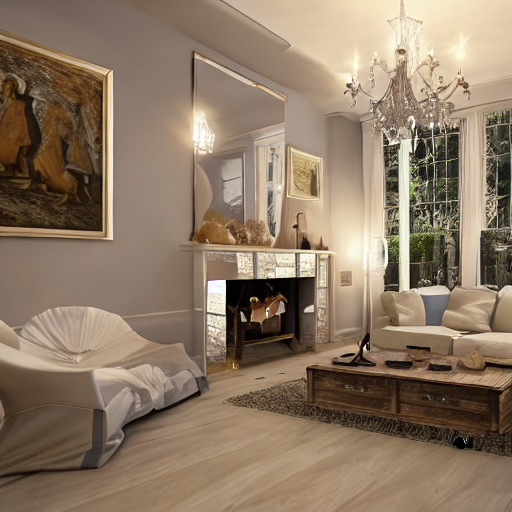

In [15]:
from PIL import Image
from IPython.display import display

# Display the generated output
display(Image.fromarray(output_image, mode="RGB"))

# Integration for Android Application (APK)

To integrate Stable Diffusion for an Android target, the following components must be available for execution on the Android platform:

- Embedding Function
- Tokenizer
- Scheduler
- QNN functions

#### <u> Embedding Function </u> ####

Implement the `get_time_embedding(timestep)` function for Android to dump the time embeddings data offline as binary files from the Python code above and read these binary files on Android for each `timestep`. There are 20 binary files for 20 iterations use-case while the number of binary files is 50 for 50 iterations run. These binary files can be packaged within the Android application (APK).

#### <u> Tokenizer </u> ####

The Tokenizer Python code can be implemented in the Rust programming language. Rust code can be compiled for Android targets.  
For details on Tokenizer Rust code, see: https://docs.rs/tokenizers/latest/tokenizers/  
For information on compiling Rust code for Android targets, see: https://mozilla.github.io/firefox-browser-architecture/experiments/2017-09-21-rust-on-android.html

#### <u> Scheduler </u> ####

To run Scheduler on Android, you can write the Scheduler Python code in C++ and compile the code for Android to generate a shared library. This library can be used to call the scheduler step function.  
Scheduler Python source code can be found in the Python `diffusers` package installation directory: `/usr/local/lib/<python-ver>/dist-packages/diffusers/schedulers/scheduling_dpmsolver_multistep.py`  

#### <u> Inference execution using Qualcomm AI Engine Direct APIs </u> ####

The Qualcomm AI Engine Direct SDK provides shared libraries for the Android platform and APIs that application developers can use to access the HTP accelerator on a Snapdragon Gen2 device. See  <QNN_SDK>/docs/QNN/general/sample_app.html for details to develop an Android application that exercises QNN APIs to execute a ML work-load on the HTP accelerator.

<div class="alert alert-info">
<b> Note to Android app developer </b>  Developers MUST ensure that the U-Net context-binary is loaded before the context-binary for VAE or text-encoder is loaded. This is a strict requirement on the Android application developer in-order to run Stable diffusion model on a Snapdragon Gen2 devices.
</div>
<br> <br>

# Final comments

Congratulations!

You have successfully worked through all the steps needed to execute the Stable Diffusion model using the Qualcomm AI Engine Direct SDK on a Qualcomm Snapdragon Android device.



Copyright (c) 2023 Qualcomm Technologies, Inc. and/or its subsidiaries.